# Setup

In [1]:
# Define Parameters
batch_size = 32
epochs = 5
task = 'Damage_Severity_Classification'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.nn as nn
import torch.optim
import torchvision.models as models
import torchvision.transforms as transforms
import warnings
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

device = torch.device("cuda:0")
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
# Damage Severity
train_path = 'C:/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_train_final.tsv'
test_path = 'C:/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_test_final.tsv'
dev_path = 'C:/crisis_vision_benchmarks/tasks/damage_severity/consolidated/consolidated_damage_dev_final.tsv'

train_label = pd.read_table(train_path)
test_label = pd.read_table(test_path)
dev_label = pd.read_table(dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(28319, 4)
(3865, 4)
(2712, 4)


In [4]:
class_label_map = {"severe": 2, "mild": 1, "little_or_none": 0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label']

    X, y, valid_indices = [], [], []

    tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    for i in tqdm(range(len(image_path))):
        path = os.path.join('C:/crisis_vision_benchmarks/', image_path[i])
        try:
            img = Image.open(path)
            if img is None:
                print(f"Error reading image: {path}")
                continue
            img = img.resize((224, 224))
            img = img.convert("RGB")
            img = np.array(img, dtype=np.float32) / 255.0
            img = tfms(img) 
            X.append(img)
            valid_indices.append(i)
        except Exception as e:
            print(f"Error opening image: {path} - {str(e)}")
            continue

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for idx in tqdm(valid_indices):
        label = class_label[idx]
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

In [5]:
X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
trainset = TensorDataset(X_train, y_train)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
testset = TensorDataset(X_test, y_test)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)
devset = TensorDataset(X_dev, y_dev)

100%|██████████| 28319/28319 [06:19<00:00, 74.67it/s] 


torch.Size([3, 224, 224])
(28319, 3, 224, 224)


100%|██████████| 28319/28319 [00:00<00:00, 1348652.18it/s]


(28319,)


100%|██████████| 3865/3865 [00:58<00:00, 66.50it/s] 


torch.Size([3, 224, 224])
(3865, 3, 224, 224)


100%|██████████| 3865/3865 [00:00<00:00, 386528.02it/s]


(3865,)


100%|██████████| 2712/2712 [00:38<00:00, 70.21it/s] 


torch.Size([3, 224, 224])
(2712, 3, 224, 224)


100%|██████████| 2712/2712 [00:00<00:00, 1355936.64it/s]

(2712,)


In [6]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

# ResNet50_Scratch

In [14]:
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [15]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [16]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet50_scratch.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [17]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/5 - loss: 0.9197 - accuracy: 58.17% - val_loss: 1.0704 - val_accuracy: 49.44% - time: 203.16s
Epoch 2/5 - loss: 0.8414 - accuracy: 64.01% - val_loss: 1.1107 - val_accuracy: 48.85% - time: 203.52s
Epoch 3/5 - loss: 0.8113 - accuracy: 65.60% - val_loss: 0.9148 - val_accuracy: 60.78% - time: 193.19s
Epoch 4/5 - loss: 0.7922 - accuracy: 66.57% - val_loss: 0.9290 - val_accuracy: 61.03% - time: 192.62s
Epoch 5/5 - loss: 0.7741 - accuracy: 67.46% - val_loss: 0.9882 - val_accuracy: 58.97% - time: 193.12s


In [18]:
print(task + '_ResNet50_scratch Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet50_scratch Classification Report:')
print(cr)

Damage_Severity_Classification_ResNet50_scratch Performance:
Accuracy : 61.11%
F1-Score : 54.83%
Damage_Severity_Classification_ResNet50_scratch Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.70      2135
           1       0.67      0.01      0.02       629
           2       0.45      0.71      0.55      1101

    accuracy                           0.59      3865
   macro avg       0.61      0.47      0.43      3865
weighted avg       0.63      0.59      0.55      3865



## Visualize Results & Confusion Matrix

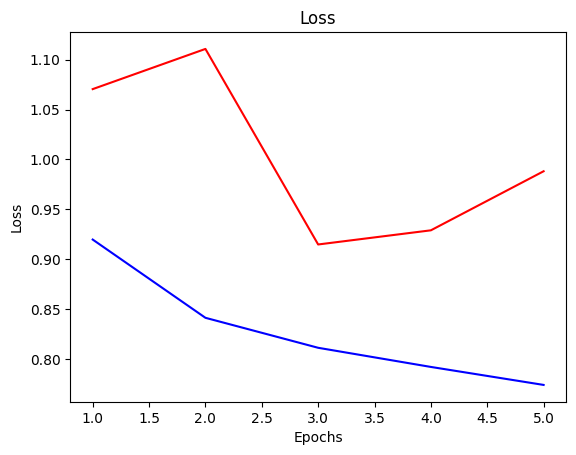

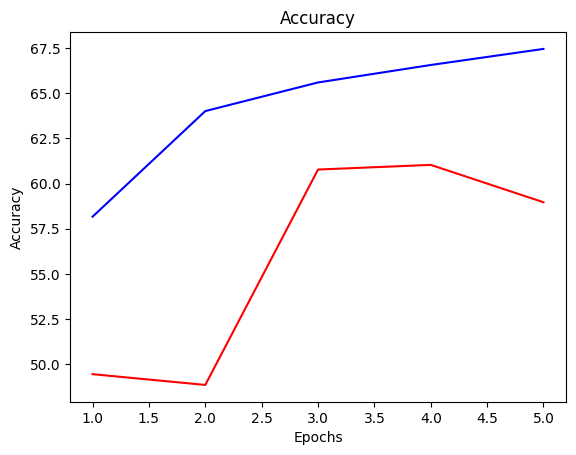

In [19]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Damage_Severity_Classification_ResNet50_scratch Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


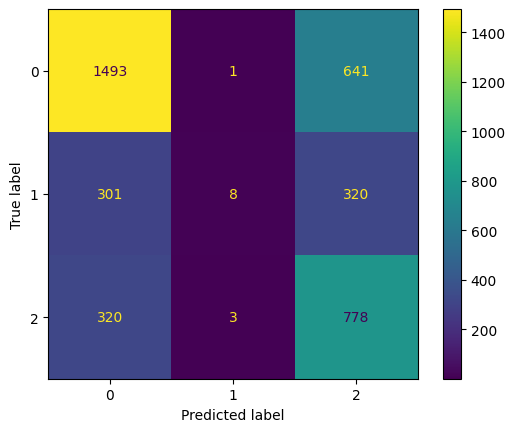

In [20]:
# "severe": 2, "mild": 1, "little_or_none": 0
print(task + '_ResNet50_scratch Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# EfficientNetb1_scratch

In [28]:
model = models.efficientnet_b1(weights=None)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [29]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [30]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_EfficientNetb1_scratch.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [31]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/5 - loss: 1.0298 - accuracy: 46.21% - val_loss: 1.0688 - val_accuracy: 39.46% - time: 163.29s
Epoch 2/5 - loss: 0.9611 - accuracy: 54.26% - val_loss: 0.9828 - val_accuracy: 52.26% - time: 159.91s
Epoch 3/5 - loss: 0.9017 - accuracy: 60.21% - val_loss: 0.9558 - val_accuracy: 56.87% - time: 158.39s
Epoch 4/5 - loss: 0.8667 - accuracy: 62.66% - val_loss: 0.9759 - val_accuracy: 57.57% - time: 158.60s
Epoch 5/5 - loss: 0.8463 - accuracy: 63.57% - val_loss: 0.9524 - val_accuracy: 57.59% - time: 159.07s


In [32]:
print(task + '_EfficientNetb1_scratch Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_EfficientNetb1_scratch Classification Report:')
print(cr)

Damage_Severity_Classification_EfficientNetb1_scratch Performance:
Accuracy : 57.63%
F1-Score : 52.89%
Damage_Severity_Classification_EfficientNetb1_scratch Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.74      0.70      2135
           1       0.00      0.00      0.00       629
           2       0.44      0.59      0.50      1101

    accuracy                           0.58      3865
   macro avg       0.37      0.44      0.40      3865
weighted avg       0.49      0.58      0.53      3865



## Visualize Results & Confusion Matrix

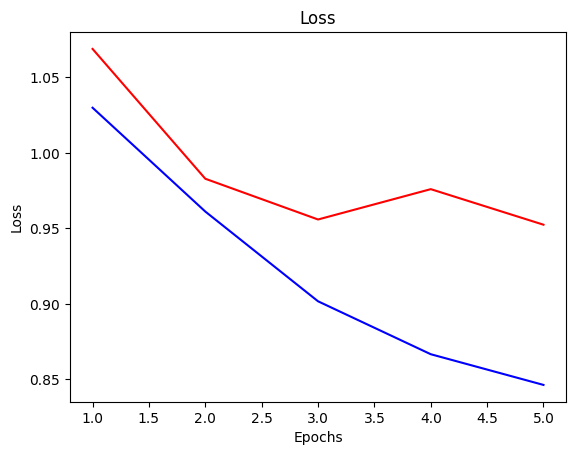

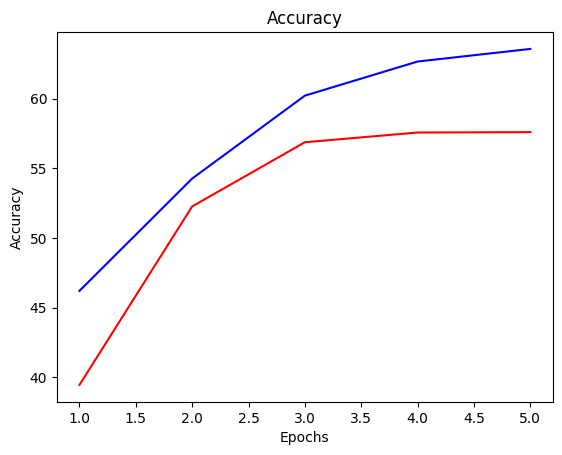

In [33]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Damage_Severity_Classification_EfficientNetb1_scratch Confusion Matrix:

severe: 2, mild: 1, little_or_none: 0


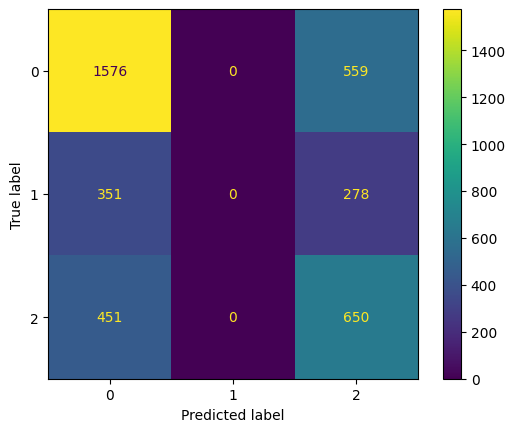

In [34]:
# "severe": 2, "mild": 1, "little_or_none": 0
print(task + '_EfficientNetb1_scratch Confusion Matrix:\n')
print('severe: 2, mild: 1, little_or_none: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()